In [1]:
from tqdm import tqdm
import glob
import numpy as np
from uuid import UUID
import lz4

from pit30m.data.partitions import PreProcessPartition, GeoPartition, QueryBasePartition
from pit30m.camera import CamName
from pit30m import LogReader

%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
with open("../pit30m/all_logs.txt", "r") as f:
    logs = f.readlines()
    logs = sorted([x.strip() for x in logs])

# logs = []
# for f in glob.glob("/home/julieta/pit30m_partitions/utm_poses_dense/to_hide/*"):
# print(logs)
#     logs.append(f.split("/")[-1][:-4])

logs = logs[:50]
print(logs)

['00682fa6-2183-4a0d-dcfe-bc38c448090f', '006ce26a-cd92-4b90-ec10-454da73ede13', '009334fa-acb9-4813-c60c-1916c83974c8', '00a05077-a8f6-4f08-ee38-c7bc4e885611', '0106abc2-b689-464a-cfe4-9f6a00089733', '017be362-c6cf-47fe-e317-fdcf128ce85a', '01959149-0840-4eba-e0a0-53c6b2bb0f84', '01c3ae4e-2bb6-4bd1-efc9-bfb16e4bd1e3', '01d09d4c-329a-4952-f2ed-555aa76dab2c', '01e21524-2e61-4ea6-cf98-164bcb2d29ab', '01e86404-c224-4b10-d12e-9e2144626b3b', '020465aa-b3f0-4b8e-c6af-b535078fe30c', '020829cb-e2a3-4160-df19-8bd4682f1115', '0209f084-2efb-4acf-f2ce-e8f8a58c8b06', '021286dc-5fe5-445f-e5fa-f875f2eb3c57', '024e8e83-7778-496f-e3c4-dfd7c0875d2d', '025c3909-7fe4-4817-e386-5d2de975363a', '025e793e-e8eb-4c6d-e074-accb77dbe4d3', '027a633e-c9d0-4340-fa28-50bf842e6d2c', '0281c09f-836a-4cfa-dcbd-77f1349b6b96', '0308a5d9-6e4c-498f-e7ef-c75e8ae721af', '0330dec6-1dbe-44d8-e139-723f2b7be005', '03359966-92d2-44d5-df29-3f391645f9ab', '03709ebf-bcce-43c5-dd63-9170b2a74836', '037e11f7-2300-47ad-e41d-9d87c2ec218f',

In [8]:
log_readers = {}
for logid in logs:
    # log_readers[logid] = LogReader(f"s3://pit30m/{logid}/", index_version=1)
    log_readers[logid] = LogReader(
        f"s3://pit30m/{logid}/", 
        index_version=1, 
        # partitions=[PreProcessPartition.VALID, GeoPartition.TRAIN],
        partitions=[PreProcessPartition.VALID, GeoPartition.TEST, QueryBasePartition.QUERY],
    )

  4%|▍         | 2/50 [00:04<01:31,  1.90s/it]

0 poses included so far
0 poses included so far


  6%|▌         | 3/50 [00:04<00:52,  1.11s/it]

0 poses included so far


  8%|▊         | 4/50 [00:11<02:38,  3.45s/it]

535 poses included so far


 10%|█         | 5/50 [00:14<02:22,  3.18s/it]

535 poses included so far


 12%|█▏        | 6/50 [00:20<03:03,  4.17s/it]

551 poses included so far


 16%|█▌        | 8/50 [00:28<02:35,  3.71s/it]

551 poses included so far
552 poses included so far


 18%|█▊        | 9/50 [00:31<02:19,  3.40s/it]

552 poses included so far


 20%|██        | 10/50 [00:38<03:00,  4.50s/it]

2_530 poses included so far


 24%|██▍       | 12/50 [00:45<02:22,  3.75s/it]

2_530 poses included so far
2_530 poses included so far


 26%|██▌       | 13/50 [00:51<02:41,  4.36s/it]

2_530 poses included so far


 28%|██▊       | 14/50 [00:55<02:36,  4.34s/it]

2_530 poses included so far


 30%|███       | 15/50 [01:00<02:32,  4.36s/it]

2_530 poses included so far


 32%|███▏      | 16/50 [01:07<03:01,  5.34s/it]

2_530 poses included so far


 34%|███▍      | 17/50 [01:14<03:06,  5.65s/it]

2_530 poses included so far


/home/julieta/pit30m/pit30m/data/log_reader.py:162: UserWarning: Persisting input arguments took 0.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  partition_indices = self._partition_assigments
 36%|███▌      | 18/50 [01:27<04:19,  8.10s/it]

2_530 poses included so far


/home/julieta/pit30m/pit30m/data/log_reader.py:162: UserWarning: Persisting input arguments took 0.76s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  partition_indices = self._partition_assigments
 38%|███▊      | 19/50 [01:45<05:37, 10.89s/it]

2_530 poses included so far


 40%|████      | 20/50 [01:50<04:35,  9.19s/it]

2_530 poses included so far


 42%|████▏     | 21/50 [01:59<04:23,  9.07s/it]

2_530 poses included so far


 44%|████▍     | 22/50 [01:59<03:03,  6.56s/it]

2_531 poses included so far


 46%|████▌     | 23/50 [02:05<02:49,  6.28s/it]

2_828 poses included so far


 48%|████▊     | 24/50 [02:11<02:38,  6.09s/it]

3_058 poses included so far


 50%|█████     | 25/50 [02:13<02:06,  5.05s/it]

3_412 poses included so far


 52%|█████▏    | 26/50 [02:14<01:30,  3.79s/it]

3_413 poses included so far


 54%|█████▍    | 27/50 [02:22<01:54,  4.96s/it]

3_635 poses included so far


 56%|█████▌    | 28/50 [02:23<01:21,  3.71s/it]

3_635 poses included so far


 58%|█████▊    | 29/50 [02:26<01:16,  3.65s/it]

3_635 poses included so far


 60%|██████    | 30/50 [02:32<01:27,  4.36s/it]

4_037 poses included so far


 62%|██████▏   | 31/50 [02:37<01:23,  4.38s/it]

4_037 poses included so far


/home/julieta/pit30m/pit30m/data/log_reader.py:162: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  partition_indices = self._partition_assigments
 64%|██████▍   | 32/50 [02:53<02:24,  8.04s/it]

4_373 poses included so far


 66%|██████▌   | 33/50 [02:54<01:39,  5.85s/it]

4_373 poses included so far


 68%|██████▊   | 34/50 [02:59<01:28,  5.54s/it]

4_373 poses included so far


 70%|███████   | 35/50 [03:08<01:39,  6.64s/it]

4_373 poses included so far


 72%|███████▏  | 36/50 [03:09<01:07,  4.85s/it]

4_373 poses included so far


/home/julieta/pit30m/pit30m/data/log_reader.py:162: UserWarning: Persisting input arguments took 0.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  partition_indices = self._partition_assigments
 74%|███████▍  | 37/50 [03:24<01:42,  7.87s/it]

4_373 poses included so far


 76%|███████▌  | 38/50 [03:27<01:19,  6.59s/it]

4_373 poses included so far


 78%|███████▊  | 39/50 [03:32<01:06,  6.06s/it]

4_527 poses included so far


 80%|████████  | 40/50 [03:39<01:02,  6.27s/it]

4_527 poses included so far


 82%|████████▏ | 41/50 [03:40<00:42,  4.73s/it]

4_611 poses included so far


/home/julieta/pit30m/pit30m/data/log_reader.py:162: UserWarning: Persisting input arguments took 0.75s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  partition_indices = self._partition_assigments
 84%|████████▍ | 42/50 [04:00<01:14,  9.31s/it]

6_491 poses included so far


/home/julieta/pit30m/pit30m/data/log_reader.py:162: UserWarning: Persisting input arguments took 0.98s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  partition_indices = self._partition_assigments
 86%|████████▌ | 43/50 [04:23<01:34, 13.45s/it]

6_491 poses included so far


/home/julieta/pit30m/pit30m/data/log_reader.py:162: UserWarning: Persisting input arguments took 0.67s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  partition_indices = self._partition_assigments
 88%|████████▊ | 44/50 [04:41<01:28, 14.69s/it]

6_491 poses included so far


/home/julieta/pit30m/pit30m/data/log_reader.py:162: UserWarning: Persisting input arguments took 0.56s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  partition_indices = self._partition_assigments
 90%|█████████ | 45/50 [04:57<01:16, 15.20s/it]

6_491 poses included so far


/home/julieta/pit30m/pit30m/data/log_reader.py:162: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  partition_indices = self._partition_assigments
 92%|█████████▏| 46/50 [05:07<00:55, 13.77s/it]

6_493 poses included so far


 94%|█████████▍| 47/50 [05:14<00:34, 11.59s/it]

6_493 poses included so far


 96%|█████████▌| 48/50 [05:18<00:18,  9.23s/it]

6_493 poses included so far


 98%|█████████▊| 49/50 [05:27<00:09,  9.29s/it]

6_493 poses included so far


100%|██████████| 50/50 [05:32<00:00,  6.66s/it]

7_333 poses included so far
Total included: 7_333
Total with poses: 17
['00a05077-a8f6-4f08-ee38-c7bc4e885611', '017be362-c6cf-47fe-e317-fdcf128ce85a', '01c3ae4e-2bb6-4bd1-efc9-bfb16e4bd1e3', '01e21524-2e61-4ea6-cf98-164bcb2d29ab', '0330dec6-1dbe-44d8-e139-723f2b7be005', '03359966-92d2-44d5-df29-3f391645f9ab', '03709ebf-bcce-43c5-dd63-9170b2a74836', '037e11f7-2300-47ad-e41d-9d87c2ec218f', '03b212bd-5d66-4924-dc39-3a4a72683f77', '03b711e5-bca3-429c-ce73-01784bd0e66c', '03e591f9-7558-4a2d-ccaa-ca44b61a2606', '047b37d0-e575-4d15-ff99-cbf646573ccd', '05d90521-f44c-4983-de64-29e90cbb5d22', '0617a7c4-57bb-4785-c06e-79fafc5716a4', '061e6a5d-ebc4-448b-d582-b81fb635ea70', '06ca16c3-3461-40d9-ef1a-a743dd0d7731', '07ff1ba3-da2a-46ba-e1d4-75d335c729bf']


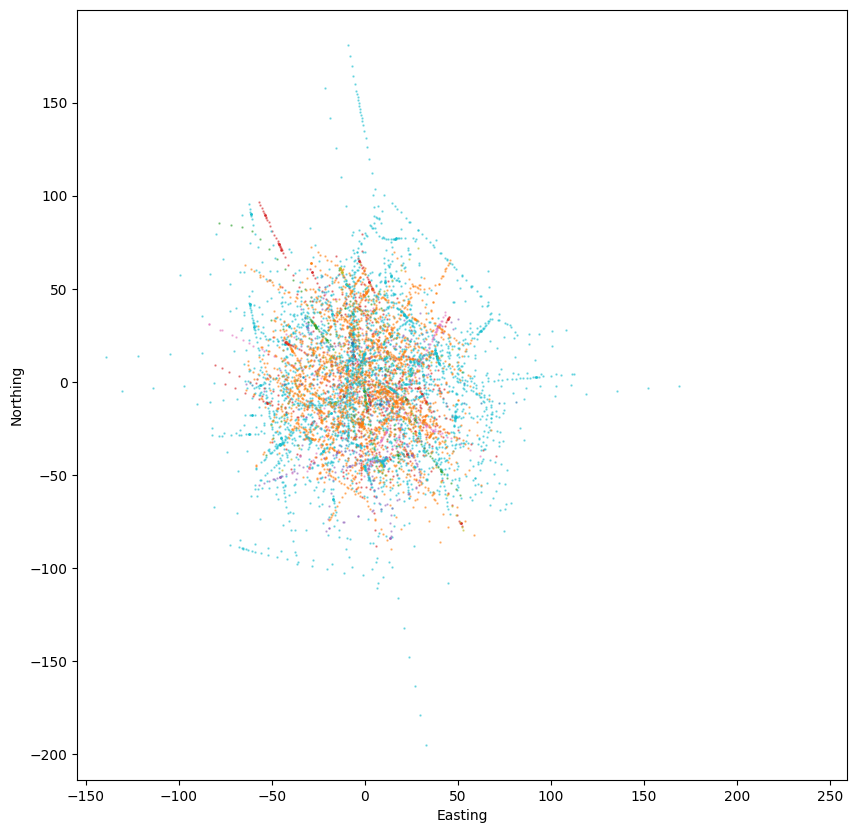

In [9]:
figsz = 20 // 2
fig = plt.figure(figsize=(figsz, figsz), dpi=100, facecolor='w', edgecolor='k')

included = 0
with_poses = []
for log_id, lr in tqdm(log_readers.items()):
    
    # camera index
    # index = lr.get_cam_geo_index(CamName.MIDDLE_FRONT_WIDE, max_delta_s=0.2)
    # utm_present = index["utm_present"]
    # x = index["utm_x"][utm_present]
    # y = index["utm_y"][utm_present]
    
    # UTM poses with offsets from the maps 
    # valid, xyzs = lr.utm_poses_dense
    # xyzs = xyzs[valid]
    # x, y = xyzs[:, 0], xyzs[:, 1]
    
    # This gives me 3_249 poses
    # pose_index = lr.continuous_pose_dense
    # x, y = pose_index[:, 2], pose_index[:, 3]
    
    # MRP dense, removing invalid, I get 2_530 poses
    pose_index = lr.map_relative_poses_dense
    pose_index = pose_index[pose_index["valid"]]
    x, y = pose_index["x"], pose_index["y"]
     
    sc = plt.scatter(x, y, s=0.5, alpha=0.5)
    
    if len(x) > 0:
        print(pose_index[0])
        with_poses.append(log_id)
    
    included += len(x)
    print(f"{included:_} poses included so far")
    
    # percent_hidden = 100 * hidden_in_log / len(utm)
    # if percent_hidden > 90: 
    #     print(f"{log_id} has {hidden_in_log:_} poses to hide ({percent_hidden:.2f}%)")

plt.axis("square")
plt.xlabel("Easting")
plt.ylabel("Northing")
print(f"Total included: {included:_}")
print(f"Total with poses: {len(with_poses)}")
print(with_poses)

In [5]:
pose_index[:, 1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
submap_ids = sorted([UUID(bytes=x.ljust(16, b"\x00")) for x in np.unique(index["submap_id"])])
print(len(submap_ids))
print(submap_ids[:10])

NameError: name 'index' is not defined

In [ ]:
from typing import Iterable
from pathlib import Path
from joblib import Parallel, delayed
import pickle
from numpy.lib import recfunctions as rfn

def get_utm_poses_with_metadata(lr):
    pose_time, pose_valid, pose_xy = lr.utm_poses_dense
    time = rfn.unstructured_to_structured(pose_time[:, np.newaxis], names=["utm_time"])
    # assert np.all(np.diff(time["utm_time"]) >= 0), "Pose times are not sorted"
    valid = rfn.unstructured_to_structured(pose_valid[:, np.newaxis], names=["utm_valid"])
    # assert len(valid) == len(pose_valid)
    xys = rfn.unstructured_to_structured(pose_xy, names=["utm_x", "utm_y"])
    # assert len(xys) == len(pose_xy)
    sensor_poses = rfn.merge_arrays([time, valid, xys], flatten=True)

    return lr.log_id, sensor_poses

def get_utm_dense_poses(
    logs: Iterable[UUID],
    logreader_path: Path = Path("/mnt/data/pit30m/pose-backup-2023-04-18/"),
    # logreader_path: Path = Path("/mnt/data/pit30m/pose-backup-2023-04-18/"),
    pool: Parallel = None,
    pickled: bool = None,
):
    """Multiple ways to get dense poses
    Args:
        logs: list of log ids whose dense poses we want to load
        logreader_path: Path where to load log readers from
        pool: pool of parallel workers to load the poses
        pickled: whether to load from a pre-dumped pickled file on disk
    """

    log_readers = [LogReader(str(logreader_path / f"{log}")) for log in logs]

    if pickled:
        # If loading from pickle, ignore everything and just load from disk
        with open("/home/julieta/pickles/utm_dense_poses.pkl", "rb") as handle:
            sensor_poses = pickle.load(handle)

        # The pickle has everything -- filter for the ones that were asked for
        sensor_poses = {log_id: sensor_pose for (log_id, sensor_pose) in sensor_poses.items() if log_id in logs}
    else:
        if pool:
            res = pool(delayed(get_utm_poses_with_metadata)(lr) for lr in log_readers)
            sensor_poses = {log_id: index for (log_id, index) in res}
        else:
            sensor_poses = {
                log_id: get_utm_poses_with_metadata(lr)[1]
                for (log_id, lr) in tqdm(
                    zip(logs, log_readers), total=len(logs), desc="Getting dense poses sequentially from disk"
                )
            }

    log_readers = {log_id: lr for (log_id, lr) in zip(logs, log_readers)}
    return sensor_poses, log_readers, pool


In [ ]:
pose_fpath = "/mnt/data/pit30m/pose-backup-2023-04-18/556af30b-cb04-4a08-ee47-4eb9e79da376/all_poses.npz.lz4"

In [ ]:
with open(pose_fpath, "rb") as in_compressed_f:
    with lz4.frame.open(in_compressed_f, "rb") as wgs84_f:
        poses = np.load(wgs84_f)["data"]

In [ ]:
submap_ids = sorted([UUID(bytes=x.ljust(16, b"\x00")) for x in np.unique(poses["map_relative"]["submap"])])
print(len(submap_ids))
print(submap_ids[:10])

136
[UUID('00a53038-3072-4115-f458-02769036233f'), UUID('02c07a67-6925-4d5e-c4e4-3a65b1e37b94'), UUID('07e78e05-8aba-421f-e1e4-27679cec69a7'), UUID('082c2a5a-7516-4f9e-fce0-6ab6eb3e0965'), UUID('0c40dc7d-1d68-4482-d48a-d3c71ff26ca4'), UUID('0cd730f5-08b5-4a91-e5c2-077134e3cb61'), UUID('0d864017-a690-4255-c225-551e3c48705f'), UUID('116570b4-6598-4c1a-da4f-948194f9d04b'), UUID('12e48274-21e0-4340-d3fa-101b21a1baab'), UUID('17b09d4c-2514-43c8-f3e3-8133a4ebc62e')]
